/Users/jiazhuangfeng/Documents/project/spatial_analysis/venv/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_4235/2475229629.py:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to ge

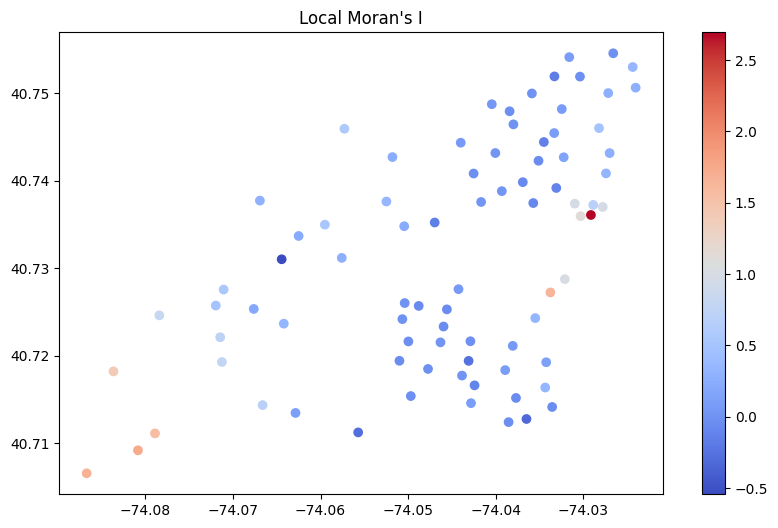

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('JC-202409-citibike-tripdata.csv')

# 聚合数据，计算每个站点的骑行次数
station_counts = data.groupby('start_station_id').size().reset_index(name='ride_count')

# 获取站点的地理位置
station_locations = data.drop_duplicates('start_station_id')[['start_station_id', 'start_lat', 'start_lng']]

# 合并数据
station_data = pd.merge(station_counts, station_locations, on='start_station_id')

# 创建 GeoDataFrame
gdf = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data.start_lng, station_data.start_lat))

# 创建权重矩阵
w = weights.DistanceBand.from_dataframe(gdf, threshold=0.01, silence_warnings=True)

# 计算局部 Moran's I
local_moran = esda.Moran_Local(gdf['ride_count'], w)

# 添加结果到 GeoDataFrame
gdf['local_moran'] = local_moran.Is
gdf['p_value'] = local_moran.p_sim

# 绘制结果
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column='local_moran', cmap='coolwarm', legend=True, ax=ax)
plt.title("Local Moran's I")
plt.show()


In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pysal.lib import weights
from pysal.explore import esda
import folium

# 读取数据
data = pd.read_csv('202409-citibike-tripdata/202409-citibike-tripdata_1.csv')

# 聚合数据，计算每个站点的骑行次数
station_counts = data.groupby('start_station_id').size().reset_index(name='ride_count')

# 获取站点的地理位置
station_locations = data.drop_duplicates('start_station_id')[['start_station_id', 'start_lat', 'start_lng']]

# 合并数据
station_data = pd.merge(station_counts, station_locations, on='start_station_id')

# 创建 GeoDataFrame
gdf = gpd.GeoDataFrame(station_data, geometry=gpd.points_from_xy(station_data.start_lng, station_data.start_lat))

# 创建权重矩阵
w = weights.DistanceBand.from_dataframe(gdf, threshold=0.01, silence_warnings=True)

# 计算局部 Moran's I
local_moran = esda.Moran_Local(gdf['ride_count'], w)

# 添加结果到 GeoDataFrame
gdf['local_moran'] = local_moran.Is
gdf['p_value'] = local_moran.p_sim

# 添加显著性水平
gdf['significant'] = gdf['p_value'] < 0.05

# 分类
gdf['category'] = 'Not Significant'
gdf.loc[(gdf['local_moran'] > 0) & (gdf['significant']), 'category'] = 'HH'
gdf.loc[(gdf['local_moran'] < 0) & (gdf['significant']), 'category'] = 'LL'
gdf.loc[(gdf['local_moran'] > 0) & (~gdf['significant']), 'category'] = 'HL'
gdf.loc[(gdf['local_moran'] < 0) & (~gdf['significant']), 'category'] = 'LH'

# 定义颜色映射
color_map = {
    'HH': 'red',
    'LL': 'blue',
    'HL': 'yellow',
    'LH': 'green',
    'Not Significant': 'gray'
}

# 创建地图对象
m = folium.Map(location=[gdf['start_lat'].mean(), gdf['start_lng'].mean()], zoom_start=13)

# 在地图上添加站点标记
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=5,
        popup=f"{row['start_station_id']}: {row['category']}",
        color=color_map[row['category']],
        fill=True,
        fill_color=color_map[row['category']]
    ).add_to(m)

# 保存地图到文件
m.save('stations_local_moran_map.html')


/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_4235/2962515163.py:9: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('202409-citibike-tripdata/202409-citibike-tripdata_1.csv')
